In [18]:
from sklearn.model_selection import cross_val_score, KFold
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from models.prepareData import getData, preprocessData, convertData, scaleData
from models.models import linearRegressionModel, PolynomialFeatures, polynomialRegression, ridgeRegressionModel, lassoRegressionModel

In [19]:
# data = getData('Bán đất', 'Vườn Lài', 'An Phú Đông', '12')
# data = getData('Bán đất', 'Ngô Chí Quốc', 'Bình Chiểu', 'Thủ Đức')
# data = getData('Bán đất', 'Nguyễn Văn Tạo', 'Long Thới', 'Nhà Bè')
data = getData('Bán đất', 'Lê Văn Lương', 'Nhơn Đức', 'Nhà Bè')

In [20]:
print("Sample data: ")
print("--------------------------------------------------------")
print(data.head())
print("--------------------------------------------------------")
print("Data Length: ", len(data))

Sample data: 
--------------------------------------------------------
  post_type   area  price        street      ward district posted_date
0   Bán đất  127.0   3.80  Lê Văn Lương  Nhơn Đức   Nhà Bè  2021-02-22
1   Bán đất   84.0   3.25  Lê Văn Lương  Nhơn Đức   Nhà Bè  2021-02-25
2   Bán đất   88.0   2.50  Lê Văn Lương  Nhơn Đức   Nhà Bè  2021-02-25
3   Bán đất   98.0   1.40  Lê Văn Lương  Nhơn Đức   Nhà Bè  2021-02-25
4   Bán đất   95.0   2.30  Lê Văn Lương  Nhơn Đức   Nhà Bè  2021-02-24
--------------------------------------------------------
Data Length:  148


In [21]:
# preporcess data:
data = preprocessData(data)

In [22]:
data = scaleData(data)

In [23]:
print("Data after after preprocessing and scaling using log transformation: ")
print("--------------------------------------------------------")
print(data.head())
print("--------------------------------------------------------")
print("Data Length: ", len(data))

Data after after preprocessing and scaling using log transformation: 
--------------------------------------------------------
   post_type      area     price        street      ward district posted_date
27   Bán đất  4.983607  1.432701  Lê Văn Lương  Nhơn Đức   Nhà Bè  2021-02-20
25   Bán đất  5.920237  1.791759  Lê Văn Lương  Nhơn Đức   Nhà Bè  2021-02-21
24   Bán đất  6.908755  1.945910  Lê Văn Lương  Nhơn Đức   Nhà Bè  2021-02-21
0    Bán đất  4.852030  1.568616  Lê Văn Lương  Nhơn Đức   Nhà Bè  2021-02-22
17   Bán đất  5.017280  1.744843  Lê Văn Lương  Nhơn Đức   Nhà Bè  2021-02-22
--------------------------------------------------------
Data Length:  85


In [24]:
# divide data into train and test:
train_data, test_data = train_test_split(data, test_size=0.2)

In [25]:
# Sort data by area column:
train_data = train_data.sort_values(by=['area'])
test_data = test_data.sort_values(by=['area'])

print("\nTrain data length: ", len(train_data))
print("Test data length: ", len(test_data))


Train data length:  68
Test data length:  17


In [26]:
# convert data into numpy
X, Y = convertData(data)
X_train, Y_train = convertData(train_data)
X_test, Y_test = convertData(test_data)

In [27]:
# find model by using linear regression:
model, linear_rmse = linearRegressionModel(X_train, Y_train)

# find Y by using linear model predict:
Y_train_pred = model.predict(X_train)
# Y_test_pred = model.predict(X_test)


Linear Regression Model: 


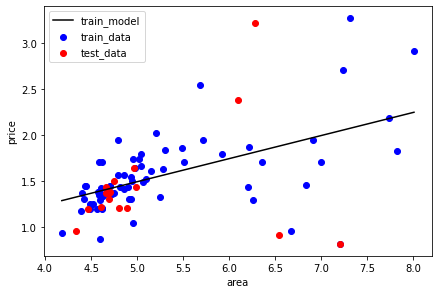

In [28]:
print("\nLinear Regression Model: ")
# Plot linear model:
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.plot(X_train, Y_train_pred, color='black', label='train_model')
plt.legend()
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [29]:
# Linear Model coefficient and intercept:
print("Linear model coefficient: {}".format(model.coef_))
print("Linear model intercept: {}".format(model.intercept_))

# linear_model rmse:
print("Linear model rmse: {}".format(linear_rmse))
print("\n\n")

Linear model coefficient: [[0.25129678]]
Linear model intercept: [0.23697621]
Linear model rmse: 0.3548230707897696





In [30]:
# find model by using polynomial regression:
poly_model, poly_rmse, degree = polynomialRegression(X_train, Y_train)

# transform X and X_test:
polynomial_features = PolynomialFeatures(degree=degree)
X_poly = polynomial_features.fit_transform(X)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.fit_transform(X_test)

# Try predicting Y
Y_train_poly_pred = poly_model.predict(X_train_poly)
Y_test_poly_pred = poly_model.predict(X_test_poly)

D:\Software\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7489757783868374, tolerance: 0.02501223002071968
  model = cd_fast.enet_coordinate_descent(
D:\Software\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1321791566475214, tolerance: 0.02501223002071968
  model = cd_fast.enet_coordinate_descent(
D:\Software\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.128976947827118, tolerance: 0.02501223002071968
  model = cd_fast.enet_coordinate_descent(
D:\Software\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

D:\Software\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.934295814580686, tolerance: 0.02501223002071968
  model = cd_fast.enet_coordinate_descent(
D:\Software\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9098460798420063, tolerance: 0.02501223002071968
  model = cd_fast.enet_coordinate_descent(
D:\Software\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8866461792167573, tolerance: 0.02501223002071968
  model = cd_fast.enet_coordinate_descent(
D:\Software\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarnin

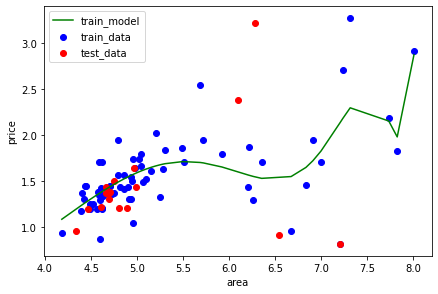

In [31]:
# Plot model:
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.plot(X_train, Y_train_poly_pred, color='green', label='train_model')
# plt.plot(X_test, Y_test_poly_pred, color='purple', label='test_model')
plt.legend()
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [32]:
print("Polynomial Regression with degree = {}".format(degree))
# Polynomial Model coefficient and intercept:
print("Polynomial model coefficient:")
print(poly_model.coef_)
print("Polynomial model intercept: {}".format(poly_model.intercept_))

# poly_model rmse:
print("Polynomial Model RMSE: {}".format(poly_rmse))

Polynomial Regression with degree = 50
Polynomial model coefficient:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.59932045e-03 -1.25223788e-04 -9.87770085e-05 -6.57020178e-06
 -3.44495733e-07  7.54889499e-11  3.68152095e-09  7.33213030e-10
  1.07026269e-10  1.35290575e-11  1.55554895e-12  1.65343265e-13
  1.62239904e-14  1.43856696e-15  1.07804962e-16  5.16813767e-18
 -2.69244777e-19 -1.30394289e-19 -2.61009902e-20 -4.20838466e-21
 -6.11563159e-22 -8.34245713e-23 -1.08900312e-23 -1.37457600e-24
 -1.68776024e-25 -2.02266585e-26 -2.36975832e-27 -2.71462600e-28
 -3.03640352e-29 -3.30576392e-30 -3.48237109e-31 -3.51165778e-32
 -3.32076260e-33 -2.81341924e-34 -1.86354259e-35 -3.07195781e-37
  2.06745187e-37  5.53265738e-38  1.04367211e-38  1.72234197e-39
  2.64561584e-40  3.88479502e-41  5.52985929e-42  7.69407218e-43
  1.05196808e-43  1.41849644e-44  1.89129442e-45]
Polynomial model intercept: [-0.08254708]
Polynomial Model RMSE: 0.30356962357662676


In [33]:
# score the model with test data:

# Linear score:
print("\n")
print("Linear Model score on train dataset: ", model.score(X_train, Y_train))
print("Linear Model score on test dataset: ", model.score(X_test, Y_test))

# Poly score:
print("\n")
print("Poly Model score on train dataset: ", poly_model.score(X_train_poly, Y_train))
print("Poly Model score on test dataset: ", poly_model.score(X_test_poly, Y_test))



Linear Model score on train dataset:  0.31544208738633406
Linear Model score on test dataset:  0.013306843991049977


Poly Model score on train dataset:  0.4989245575317458
Poly Model score on test dataset:  -0.11878715182450672
